## **Developing encoder based language model from scratch (for example: BERT) and then find the cosine similarity between the two example sentences. **

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,d_embed,hidden_dim,dropout=0.1):
    super(FeedForward,self).__init__()
    self.fc1 = nn.Linear(d_embed,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,d_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    out = self.fc1(x)
    out = F.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self,d_embed,hidden_dim,att_heads,dropout=0.1):
    super(EncoderBlock,self).__init__()
    self.attention = nn.MultiheadAttention(d_embed,att_heads,dropout=dropout)
    self.norm1 = nn.LayerNorm(d_embed)
    self.norm2 = nn.LayerNorm(d_embed)
    self.feedforward = FeedForward(d_embed,hidden_dim,dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask=None):
    attn_layer,_ = self.attention(x,x,x,attn_mask=mask)
    x = x + self.dropout(attn_layer)
    x = self.norm1(x)

    feed_layer = self.feedforward(x)
    x = x + self.dropout(feed_layer)
    x = self.norm2(x)
    return x


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_embed, hidden_dim, att_heads, encoder_blocks, dropout=0.1):
        super(Encoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, d_embed)
        self.position_embedding = nn.Embedding(1000, d_embed)  # Assuming a maximum sequence length of 1000
        self.layers = nn.ModuleList(
            [
                EncoderBlock(d_embed, hidden_dim, att_heads, dropout)
                for _ in range(encoder_blocks)
            ]
        )

    def forward(self, x, mask=None):
        seq_length = x.shape[1]
        print("sequence length", seq_length)
        print("position of one 1D layer", torch.arange(0, seq_length),torch.arange(0, seq_length).shape)
        positions = torch.arange(0, seq_length).expand(x.shape[0], seq_length).to(x.device)
        print("positions for all layers", positions, positions.shape)
        out = self.word_embedding(x) + self.position_embedding(positions)

        for layer in self.layers:
            out = layer(out, mask)
            print("out vector", out,out.shape)
        return out

In [ ]:
vocab_size = 5000
d_embed = 512
hidden_dim = 2048
att_heads = 8
dropout = 0.1
encoder_blocks = 6

model = Encoder(vocab_size,d_embed,hidden_dim,att_heads,encoder_blocks,dropout)
# Generate some example input
input_tensor = torch.randint(0, vocab_size, (1, 20))  # batch size of 1 and sequence length of 20
# input_tensor

output = model(input_tensor, mask=None)
print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

sequence length 20
position of one 1D layer tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]) torch.Size([20])
positions for all layers tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]]) torch.Size([1, 20])
out vector tensor([[[ 0.3631, -0.6862,  0.0879,  ..., -1.0542,  1.6041,  0.6024],
         [ 0.4003, -0.1185,  0.1910,  ..., -0.5335, -1.8069, -1.5514],
         [ 0.7274, -0.7057,  0.4593,  ..., -0.3196,  0.1505, -0.7418],
         ...,
         [-0.5321,  1.2067,  0.7741,  ...,  2.0038,  0.1468, -1.1930],
         [ 0.5541,  1.4369, -0.5925,  ...,  0.5318, -0.7683, -1.3132],
         [ 1.0759, -1.1018,  0.5948,  ..., -1.1793,  1.0693,  0.7971]]],
       grad_fn=<NativeLayerNormBackward0>) torch.Size([1, 20, 512])
out vector tensor([[[ 0.2740, -0.3136,  0.3824,  ..., -0.5609,  0.6310,  1.2941],
         [-0.4261, -0.2302,  0.7571,  ..., -0.0674, -1.9572, -0.9025],
         [ 1.0772, -0.5

In [ ]:
input_tensor.shape[1]

20

In [ ]:
input_tensor = torch.randint(0, vocab_size, (2, 5))  # batch size of 1 and sequence length of 5
print(input_tensor, input_tensor.shape)
# Forward pass through the model
embeddings = model(input_tensor, mask=None)

# The `embeddings` tensor now contains the contextualized embeddings for each word in the input sequence
print("embeddings vector", embeddings,embeddings.shape)

tensor([[ 733, 2444, 3837,   19, 4000],
        [ 639, 1252, 2415,  863, 3956]]) torch.Size([2, 5])
sequence length 5
position of one 1D layer tensor([0, 1, 2, 3, 4]) torch.Size([5])
positions for all layers tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]) torch.Size([2, 5])
out vector tensor([[[-0.0935, -0.8294,  0.3669,  ..., -0.6759, -0.6581, -0.0983],
         [-0.5760, -1.3439, -0.1334,  ..., -1.0576, -1.8375, -0.4444],
         [ 0.1881,  0.3343,  0.6801,  ..., -1.0758,  0.8564,  0.4377],
         [ 0.3669, -1.2716,  0.1522,  ..., -0.2428, -0.0335, -0.0656],
         [-1.4725, -0.3279, -0.6978,  ..., -0.3956, -1.9149,  0.8661]],

        [[-1.2104, -0.9359, -0.2866,  ..., -1.2313,  1.3578,  0.9891],
         [-0.3122, -1.6690,  0.8767,  ...,  0.1879, -1.8508, -0.0059],
         [-1.2221, -0.1787,  0.8609,  ..., -0.8402,  1.1618, -0.1979],
         [-0.2616, -1.2194, -1.3485,  ..., -0.1855,  0.5551,  0.7014],
         [-1.5890,  0.1638, -0.8815,  ...,  0.8085, -1.0715,  1.3763]]

In [ ]:
vocabulary = [
    "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]",
    "the", "a", "an",
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    "runs", "jumps", "sleeps", "eats", "drinks",
    "fast", "slow", "big", "small", "red", "green", "blue", "yellow",
    "is", "was", "will", "can", "has", "have", "had", "do", "does",
    "I", "you", "he", "she", "it", "we", "they",
    "my", "your", "his", "her", "its", "our", "their"
]

word2id = {word:id for id,word in enumerate(vocabulary)}
print(word2id)

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'the': 5, 'a': 6, 'an': 7, 'cat': 8, 'dog': 9, 'fish': 10, 'bird': 11, 'lion': 12, 'tiger': 13, 'elephant': 14, 'monkey': 15, 'runs': 16, 'jumps': 17, 'sleeps': 18, 'eats': 19, 'drinks': 20, 'fast': 21, 'slow': 22, 'big': 23, 'small': 24, 'red': 25, 'green': 26, 'blue': 27, 'yellow': 28, 'is': 29, 'was': 30, 'will': 31, 'can': 32, 'has': 33, 'have': 34, 'had': 35, 'do': 36, 'does': 37, 'I': 38, 'you': 39, 'he': 40, 'she': 41, 'it': 42, 'we': 43, 'they': 44, 'my': 45, 'your': 46, 'his': 47, 'her': 48, 'its': 49, 'our': 50, 'their': 51}


In [ ]:
def embeddings(sentence, word2id, model):
  input_tensor = torch.tensor([word2id.get(word,word2id["[UNK]"]) for word in sentence.split()],dtype=torch.long).unsqueeze(0)
  print(input_tensor)
  #create embeddings for the given input tensor
  embeddings = model(input_tensor, mask = None)
  return embeddings

def cosine_similarity(avg_embeddings1,avg_embeddings2):
  vec1 = avg_embeddings1.squeeze()
  vec2 = avg_embeddings2.squeeze()
  print("squeezed average vectors", vec1.shape,vec2.shape)
  score = torch.dot(vec1,vec2)/(torch.norm(vec1)*torch.norm(vec2))
  print("cosine similarity",score)
  return score

def sentence_similarity(sentence1, sentence2, model, word2id):
  #create embeddings
  embeddings1 = embeddings(sentence1, word2id, model)
  embeddings2 = embeddings(sentence2, word2id, model)
  print("shape of embeddings", embeddings1.shape, embeddings2.shape)
  #create avg embeddings
  avg_embeddings1 = torch.mean(embeddings1,dim=1)
  avg_embeddings2 = torch.mean(embeddings2,dim=1)
  print("shape of average embeddings", avg_embeddings1.shape, avg_embeddings2.shape)
  return cosine_similarity(avg_embeddings1, avg_embeddings2)

sentence1 = "the cat has a blue fish"
sentence2 = "my sister's dog sleeps"
# Compute the similarity
similarity = sentence_similarity(sentence1, sentence2, model, word2id)

similarity_score = similarity.item()

# Print the result with a descriptive sentence
print(f"The cosine similarity between the sentences '{sentence1}' and '{sentence2}' is {similarity_score:.2f}.")


tensor([[ 5,  8, 33,  6, 27, 10]])
sequence length 6
position of one 1D layer tensor([0, 1, 2, 3, 4, 5]) torch.Size([6])
positions for all layers tensor([[0, 1, 2, 3, 4, 5]]) torch.Size([1, 6])
out vector tensor([[[-0.7262, -1.5774,  0.0859,  ..., -1.1739, -0.4944,  0.4838],
         [-0.0937, -0.0896, -0.1088,  ...,  0.2291, -1.5948, -0.6910],
         [ 0.8018, -0.5499,  0.3774,  ...,  0.2341,  0.7330, -0.0585],
         [-0.9522, -0.6955, -0.3501,  ..., -0.3861, -0.6361, -1.3149],
         [-0.3444, -0.8203, -0.7973,  ...,  1.2745, -1.2774, -1.0654],
         [-0.1359,  0.0513, -0.0688,  ..., -1.0458,  1.2697,  1.2602]]],
       grad_fn=<NativeLayerNormBackward0>) torch.Size([1, 6, 512])
out vector tensor([[[-0.8838, -1.1757,  0.4585,  ..., -0.7339, -0.6350,  1.0274],
         [-0.3862,  0.1466, -0.4369,  ..., -0.4265, -1.7591, -0.0285],
         [ 0.4859, -0.4289, -0.0328,  ...,  0.2406,  0.0092, -0.1316],
         [-0.9911, -0.0372,  0.1230,  ..., -0.5993, -0.0326, -0.6765],
     

[[0.46318314 0.92497816 0.65649075 ... 0.43564885 0.42814781 0.71272477]
 [0.4279083  0.24473884 0.7594888  ... 0.77780949 0.96080824 0.80487967]
 [0.03405757 0.04570341 0.37375317 ... 0.94080722 0.92222401 0.21540423]
 ...
 [0.87892524 0.49504611 0.15502849 ... 0.66383154 0.16947101 0.48770468]
 [0.42293537 0.27627881 0.49248136 ... 0.92036636 0.97967733 0.24926939]
 [0.91462711 0.56188413 0.52197311 ... 0.87677886 0.24837401 0.32881073]]


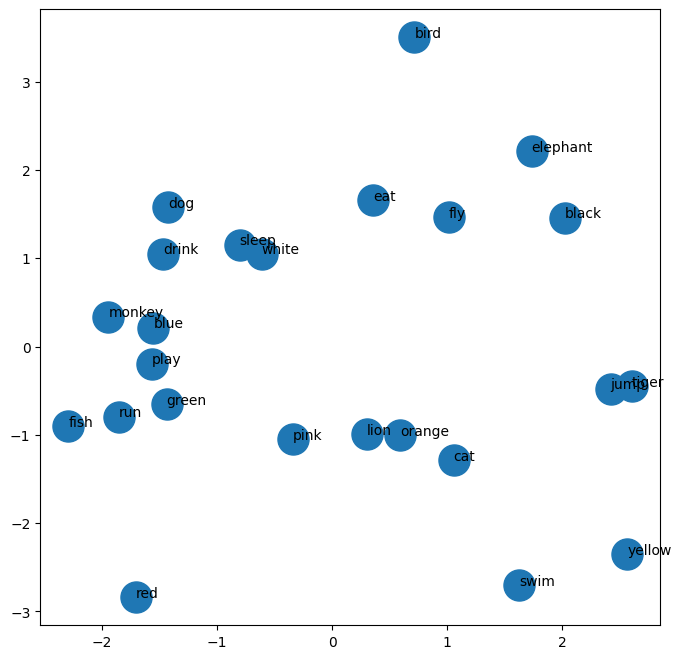

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]
# words = vocabulary
embeddings = np.array([np.random.rand(512) for _ in words])
print(embeddings)
# embeddings.shape
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
# embeddings_2d
plt.figure(figsize=(8,8))
plt.scatter(embeddings_2d[:,0],embeddings_2d[:,1],s=500)
for i,word in enumerate(words):
  plt.annotate(word,xy=(embeddings_2d[i,0],embeddings_2d[i,1]))
plt.show()



### Masked Language Modeling with BERT

We load a pre-trained BERT model that has been fine-tuned for the masked language modeling (MLM) task. We then define a function to predict the word that should fill a `[MASK]` token in a sentence.

In [ ]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-uncased"
model_bert = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

torch.Size([24, 768])


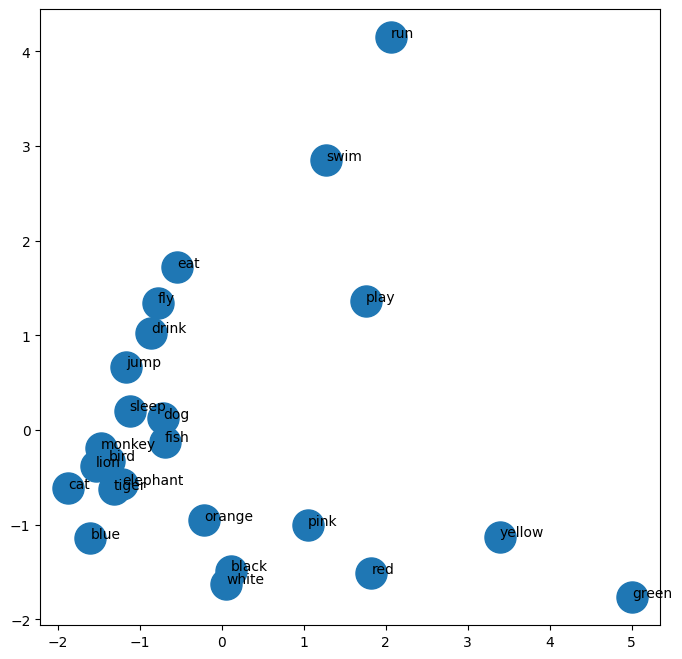

In [ ]:
# Define a list of words to plot
words = [
    # Animals
    "cat", "dog", "fish", "bird", "lion", "tiger", "elephant", "monkey",
    # Colors
    "red", "green", "blue", "yellow", "black", "white", "pink", "orange",
    # Verbs
    "run", "jump", "swim", "fly", "eat", "drink", "sleep", "play"
]

# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs)
    # embeddings.append(outputs.logits.mean(dim=1).squeeze().numpy())
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())


print(torch.tensor(embeddings).shape)
# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

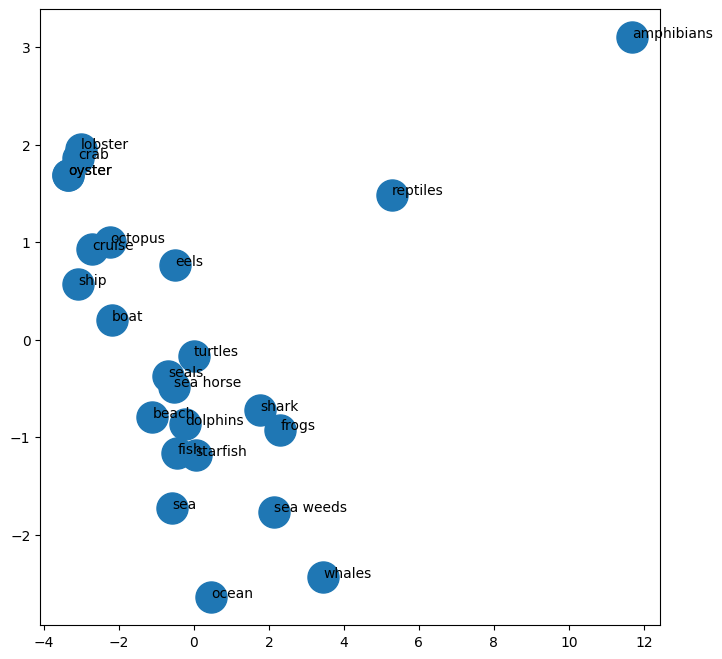

In [ ]:
words = [
    # Animals
    "sea horse", "fish", "turtles", "sea weeds", "shark", "whales", "dolphins", "oyster",
    # Colors
    "crab", "beach", "sea", "ocean", "ship", "boat", "cruise", "seals",
    # Verbs
    "octopus", "starfish", "reptiles", "lobster", "amphibians", "frogs", "oyster", "eels"
]

# Get the embeddings of the words
embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model_bert(**inputs)
    # print(outputs["last_hidden_state"], outputs["last_hidden_state"].shape)
    # print(outputs.last_hidden_state[0, 0, :],outputs.last_hidden_state[0, 0, :].shape)
    embeddings.append(outputs.last_hidden_state[0, 0, :].numpy())

# Use PCA to reduce the dimensionality of the embeddings to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],s=500)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define a function to predict masked words
from transformers import BertTokenizer, BertForMaskedLM

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
mlm_model = BertForMaskedLM.from_pretrained("bert-base-uncased")

# Define a function to predict masked words
def predict_masked_words(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    print(inputs, outputs["logits"].shape)
    predicted_token_ids = outputs.logits.argmax(dim=-1)
    print(predicted_token_ids, predicted_token_ids.shape)
    print(predicted_token_ids.squeeze(0))
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_token_ids[0])
    print(predicted_tokens)
    return " ".join(predicted_tokens)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define a sentence with a masked word
sentence = "I love to play [MASK] ball."
print(predict_masked_words(sentence, mlm_model, tokenizer))

{'input_ids': tensor([[ 101, 1045, 2293, 2000, 2377,  103, 3608, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 9, 30522])
tensor([[1012, 1045, 2293, 2000, 2377, 1996, 3608, 1012, 1045]]) torch.Size([1, 9])
tensor([1012, 1045, 2293, 2000, 2377, 1996, 3608, 1012, 1045])
['.', 'i', 'love', 'to', 'play', 'the', 'ball', '.', 'i']
. i love to play the ball . i


In [ ]:
sentences = [
    "The weather today is [MASK].",
    "I like to eat [MASK] for breakfast.",
    "She is a [MASK] woman.",
    "He drives a [MASK] car.",
    "They are going to the [MASK]."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

{'input_ids': tensor([[ 101, 1996, 4633, 2651, 2003,  103, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 8, 30522])
tensor([[1012, 1996, 4633, 2651, 2003, 4010, 1012, 1012]]) torch.Size([1, 8])
tensor([1012, 1996, 4633, 2651, 2003, 4010, 1012, 1012])
['.', 'the', 'weather', 'today', 'is', 'warm', '.', '.']
. the weather today is warm . .
{'input_ids': tensor([[ 101, 1045, 2066, 2000, 4521,  103, 2005, 6350, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 10, 30522])
tensor([[1012, 1045, 2066, 2000, 4521, 2009, 2005, 6350, 1012, 1045]]) torch.Size([1, 10])
tensor([1012, 1045, 2066, 2000, 4521, 2009, 2005, 6350, 1012, 1045])
['.', 'i', 'like', 'to', 'eat', 'it', 'for', 'breakfast', '.', 'i']
. i like to eat it for breakfast . i
{'input_ids': tensor([[ 101, 2016, 2003, 1037,  103, 2450, 1012,  102]

In [ ]:
sentences = [
    "My favorite color is [MASK].",
    "The cat sat on the [MASK].",
    "I am reading a [MASK] book.",
    "She has a [MASK] of apples.",
    "He plays the [MASK] in a band."
]

# Use the model to predict the masked words
for sentence in sentences:
    print(predict_masked_words(sentence, mlm_model, tokenizer))

{'input_ids': tensor([[ 101, 2026, 5440, 3609, 2003,  103, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 8, 30522])
tensor([[1012, 2026, 5440, 3609, 2003, 5061, 1012, 1012]]) torch.Size([1, 8])
tensor([1012, 2026, 5440, 3609, 2003, 5061, 1012, 1012])
['.', 'my', 'favorite', 'color', 'is', 'pink', '.', '.']
. my favorite color is pink . .
{'input_ids': tensor([[ 101, 1996, 4937, 2938, 2006, 1996,  103, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 9, 30522])
tensor([[1012, 1996, 4937, 2938, 2006, 1996, 2723, 1012, 1012]]) torch.Size([1, 9])
tensor([1012, 1996, 4937, 2938, 2006, 1996, 2723, 1012, 1012])
['.', 'the', 'cat', 'sat', 'on', 'the', 'floor', '.', '.']
. the cat sat on the floor . .
{'input_ids': tensor([[ 101, 1045, 2572, 3752, 1037,  103, 2338, 1012,  102]]), 'token_type_ids': tensor([[0, 0

In [ ]:
sentence_q5 = "She went to [MASK] to buy [MASK]"
print(predict_masked_words(sentence_q5, mlm_model, tokenizer))

{'input_ids': tensor([[ 101, 2016, 2253, 2000,  103, 2000, 4965,  103,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 9, 30522])
tensor([[1012, 2016, 2253, 2000, 3006, 2000, 4965, 1012, 1012]]) torch.Size([1, 9])
tensor([1012, 2016, 2253, 2000, 3006, 2000, 4965, 1012, 1012])
['.', 'she', 'went', 'to', 'market', 'to', 'buy', '.', '.']
. she went to market to buy . .


In [ ]:
sentence_q6 = "Elle est allée au marché pour acheter une [MASK]."
print(predict_masked_words(sentence_q6, mlm_model, tokenizer))

{'input_ids': tensor([[  101, 15317,  9765,  2035,  4402,  8740, 28791, 10364, 12336,  3334,
         16655,   103,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 14, 30522])
tensor([[ 1012, 15317,  9765,  2035,  4402,  8740, 28791, 10364,  9932,  2102,
         16655, 20098,  1012,  1012]]) torch.Size([1, 14])
tensor([ 1012, 15317,  9765,  2035,  4402,  8740, 28791, 10364,  9932,  2102,
        16655, 20098,  1012,  1012])
['.', 'elle', 'est', 'all', '##ee', 'au', 'marche', 'pour', 'ai', '##t', 'une', 'vie', '.', '.']
. elle est all ##ee au marche pour ai ##t une vie . .


In [ ]:
sentence_q7a = "She has [MASK] a completely sheltered life"
sentence_q7b = "A military delegation was [MASK] by the Chief of Staff"
print(predict_masked_words(sentence_q7a, mlm_model, tokenizer))
print(predict_masked_words(sentence_q7b, mlm_model, tokenizer))

{'input_ids': tensor([[  101,  2016,  2038,   103,  1037,  3294, 18304,  2166,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 9, 30522])
tensor([[ 1012,  2016,  2038,  2973,  1037,  3294, 18304,  1012,  1012]]) torch.Size([1, 9])
tensor([ 1012,  2016,  2038,  2973,  1037,  3294, 18304,  1012,  1012])
['.', 'she', 'has', 'lived', 'a', 'completely', 'sheltered', '.', '.']
. she has lived a completely sheltered . .
{'input_ids': tensor([[  101,  1037,  2510, 10656,  2001,   103,  2011,  1996,  2708,  1997,
          3095,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 12, 30522])
tensor([[ 1012,  1037,  2510, 10656,  2001,  3753,  2011,  1996,  2708,  1997,
          3095,  1012]]) torch.Size([1, 12])
tensor([ 1012,  1037,  2510, 10656,  2001,  3753,  2011,  1996,  2708,  1997,
         309

In [ ]:
sentence_q8 = "Let's tailgate before the game and grill some [MASK]."
print(predict_masked_words(sentence_q8, mlm_model, tokenizer))

{'input_ids': tensor([[  101,  2292,  1005,  1055,  5725,  5867,  2077,  1996,  2208,  1998,
         18651,  2070,   103,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 15, 30522])
tensor([[ 1012,  2292,  1005,  1055,  5725,  5867,  2077,  1996,  2208,  1998,
         18651,  2070, 21475,  1012,  1012]]) torch.Size([1, 15])
tensor([ 1012,  2292,  1005,  1055,  5725,  5867,  2077,  1996,  2208,  1998,
        18651,  2070, 21475,  1012,  1012])
['.', 'let', "'", 's', 'tail', '##gate', 'before', 'the', 'game', 'and', 'grill', 'some', 'steak', '.', '.']
. let ' s tail ##gate before the game and grill some steak . .


In [ ]:
sentence_q9 = "It costs an [MASK] and leg"
print(predict_masked_words(sentence_q9, mlm_model, tokenizer))

{'input_ids': tensor([[ 101, 2009, 5366, 2019,  103, 1998, 4190,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])} torch.Size([1, 8, 30522])
tensor([[1012, 2009, 5366, 2019, 3178, 1998, 1012, 1012]]) torch.Size([1, 8])
tensor([1012, 2009, 5366, 2019, 3178, 1998, 1012, 1012])
['.', 'it', 'costs', 'an', 'hour', 'and', '.', '.']
. it costs an hour and . .
